## A Bear Image classifer for 3 classes, including teddys, black, and grizzly

- Download your own images from Google images. Please refer to [download_images_from_google.ipynb](download_images_from_google.ipynb) for details

In [5]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

In [6]:
from fastai import *
from fastai.vision import *

In [7]:
path=Path('data/bears')
#path=Path('/home/user/git/data/bears')
#torch.cuda.set_device(1)

### Create ImageDataBunch and take a quick look at the data
- There is no separate validation set, so set aside 20% as validation data set.


['black', 'grizzly', 'teddys']
training size: 422 validate size: 105


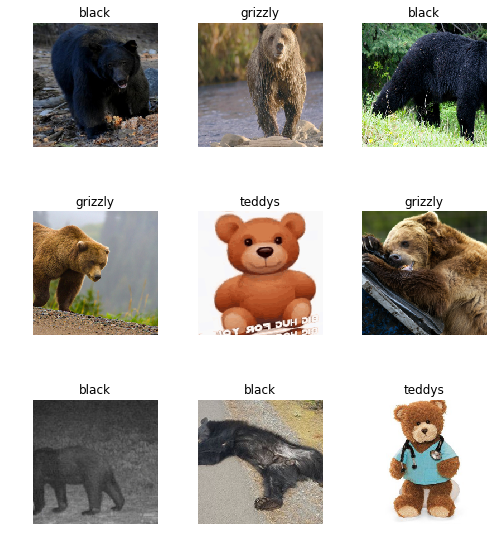

In [4]:
np.random.seed(42)
bs=64
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=bs).normalize(imagenet_stats)
print(data.classes)
print('training size: %s validate size: %s' %(len(data.train_ds), len(data.valid_ds)))
data.show_batch(rows=3, figsize=(7,8))

### Train Model
1. Usually you should use lr_finder first to find the learning rate. (default is 3e-3)
2. Train it first without unfreeze.
3. Unfreeze it and give differential learning rates and train again.
4. Do some data clean up and re-train again.

In [6]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')

In [10]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


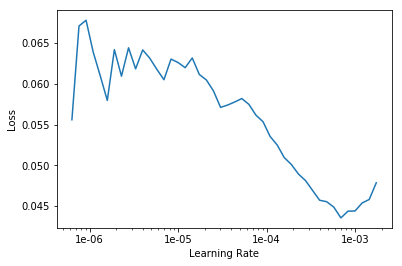

In [11]:

learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(2,max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate
1,0.069425,0.054686,0.028571
2,0.051248,0.065318,0.028571


In [13]:
learn.save('stage-2')

In [14]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (422 items)
[Category black, Category black, Category black, Category black, Category black]...
Path: data/bears
x: ImageItemList (422 items)
[Image (3, 420, 745), Image (3, 370, 470), Image (3, 569, 960), Image (3, 225, 400), Image (3, 339, 630)]...
Path: data/bears;

Valid: LabelList
y: CategoryList (105 items)
[Category grizzly, Category teddys, Category black, Category grizzly, Category black]...
Path: data/bears
x: ImageItemList (105 items)
[Image (3, 495, 728), Image (3, 454, 490), Image (3, 2592, 1944), Image (3, 600, 480), Image (3, 600, 800)]...
Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
     

### Interpretation

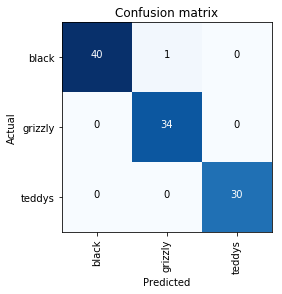

In [7]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Data Clean up and then do the re-train

In [8]:
from fastai.widgets import *

In [9]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [18]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

### Inference

In [8]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (0 items)
[]...
Path: data/bears
x: ImageItemList (0 items)
[]...
Path: data/bears;

Valid: LabelList
y: CategoryList (0 items)
[]...
Path: data/bears
x: ImageItemList (0 items)
[]...
Path: data/bears;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, mo

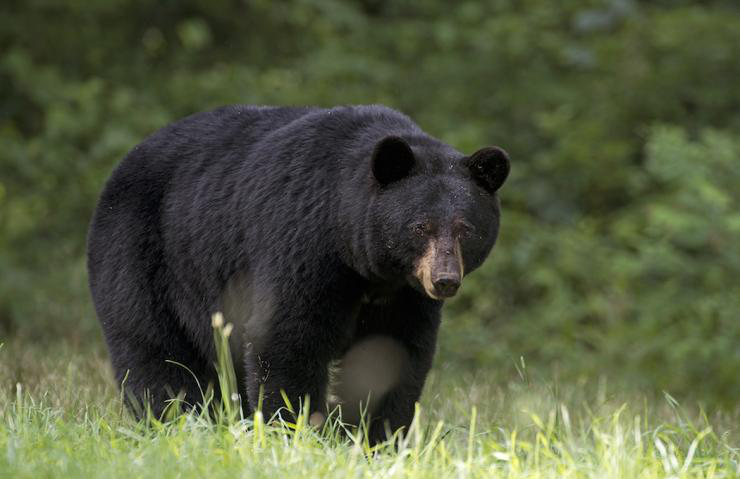

In [9]:
img = open_image(path/'black'/'00000021.jpg')
#img = open_image(path/'teddys'/'00000021.jpg')
#img = open_image(path/'grizzly'/'00000021.jpg')
img

In [10]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,pred_idx,outputs)

black tensor(0) tensor([9.9942e-01, 5.5117e-04, 2.6395e-05])


### Flask Web API to do the inference

In [ ]:
#Flask Web site
from servefastai import serve
serve(learn)

 * Serving Flask app "servefastai" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:9999/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Dec/2018 15:03:34] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:03:34] "GET /static/css/bootstrap-reboot.min.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:03:34] "GET /static/css/bootstrap.min.css HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:03:34] "GET /static/js/bootstrap.min.js HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:03:35] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [30/Dec/2018 15:04:19] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:04:19] "GET /static/js/popper.min.js HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2018 15:04:19] "GET /static/js/jquery-3.3.1.slim.min.js HTTP/1.1" 200 -


## Test Code

In [1]:
from notebook.auth import passwd
passwd()

Enter password: ········
Verify password: ········


'sha1:13f20fce2676:5f388033b2df5ada9140adb045c06b2d6bb238d2'